In [104]:
#pip install pmdarima

# CPI State Space Model Using ARIMA Method

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.The functions of use will are:
- ARIMA
- SARIMAX
- SEASONAL DECOMPOSE
- AUTO CORRELATION AND PARTIAL CORRELATION
- ACF AND PACF PLOT
- ADF FULLER - TEST
- KPSS

**Given the variety of tools, we can provide more accurate and useful predictions.**


In [105]:
#conda install seaborn

In [106]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from matplotlib import rcParams
#from cycler import cycler

#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)
print('Seaborn:', sns.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2
Seaborn: 0.11.2


In [107]:
# read in cpi data\
month = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data/cpi_avg_price_data.csv', parse_dates=['Year'], index_col='Year')

### Preprocessing

In [108]:
# Drop unncessary column
month = month.drop('Series ID', axis=1)
# Remove leaky data
month = month[:-2]
# Sum each row for univariate analysis
#month = months.sum(axis=1)

**Task**: Either use univariate or multivariate time series analysis.
If multivariate incorporate method to sum or average annual value for specific year

In [109]:
month['Cpi'] = month.sum(axis=1)

In [110]:
month['Cpi']

Year
1913-01-01     118.600
1914-01-01     120.200
1915-01-01     121.300
1916-01-01     130.600
1917-01-01     153.900
                ...   
2016-01-01    2880.086
2017-01-01    2941.435
2018-01-01    3013.282
2019-01-01    3067.889
2020-01-01    3105.734
Name: Cpi, Length: 108, dtype: float64


### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

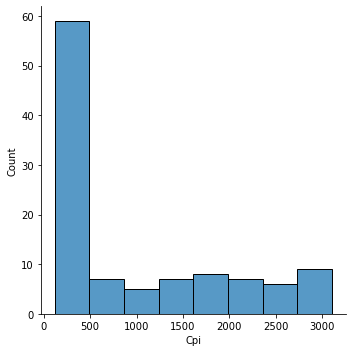

In [111]:
sns.displot(data=month['Cpi']);

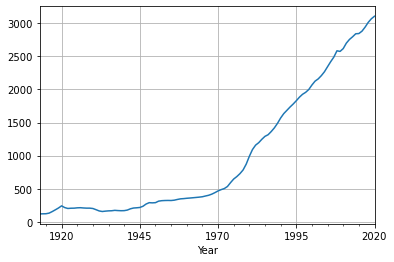

In [112]:
month['Cpi'].plot(grid=True);

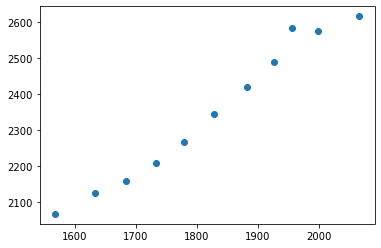

In [113]:
# Comparing 2 previous decades
plt.scatter(month['Cpi']['1990':'2000'], month['Cpi']['2000':'2010']);

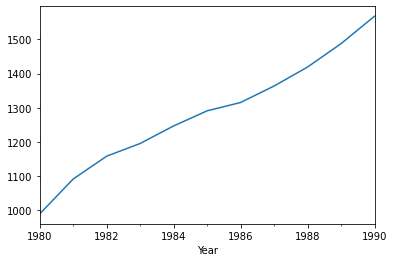

In [114]:
month['Cpi']['1980':'1990'].plot();


### Test for Stationarity

To be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [115]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['Cpi'])

(0.9110032211266553, True)

In [116]:
#from statsmodels.tsa.stattools import adfuller
## We acquire greater results through adfuller
#
#def adf_test(month):
#    print("Results of Dickey-Fuller Test:")
#    dftest = adfuller(month['Cpi'], autolag="AIC")
#    dfoutput = pd.Series(
#        dftest[0:4],
#        index=[
#            "Test Statistic",
#            "p-value",
#            "#Lags Used",
#            "Number of Observations Used",
#        ],
#    )
#    for key, value in dftest[4].items():
#        dfoutput["Critical Value (%s)" % key] = value
#    print(dfoutput)
#    
#
#    
#adf_test(month)

In [117]:
#from statsmodels.tsa.stattools import kpss
#
#
#def kpss_test(month):
#    print("Results of KPSS Test:")
#    kpsstest = kpss(month['Cpi'], regression="ct", nlags="auto")
#    kpss_output = pd.Series(
#        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
#    )
#    for key, value in kpsstest[3].items():
#        kpss_output["Critical Value (%s)" % key] = value
#    print(kpss_output)
#    
#    
#    
#kpss_test(month)

In [118]:
# Reject the null hypothesis - test statistic actual pvalue smaller
#sm.tsa.stattools.kpss(month, regression='ct')

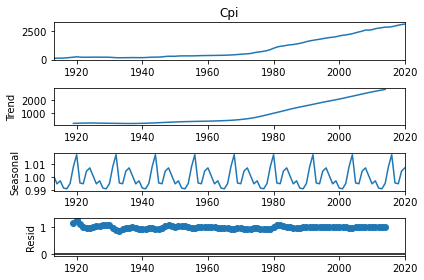

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['Cpi'],period=12,model='multiplicative')
seas_dcomp.plot();


### Make Series Stationary Using Log Transform


In [120]:
#Transform the data from non-statinary to stationary
month_log = np.log(month['Cpi'])
month_diff = month_log.diff().dropna()

In [121]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -4.223977
p-value: 0.000600
Critical values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


In [122]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.080000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [123]:
#month_new = month['Cpi']
#month_24 = month_new[777:-7]
#month_24.shape

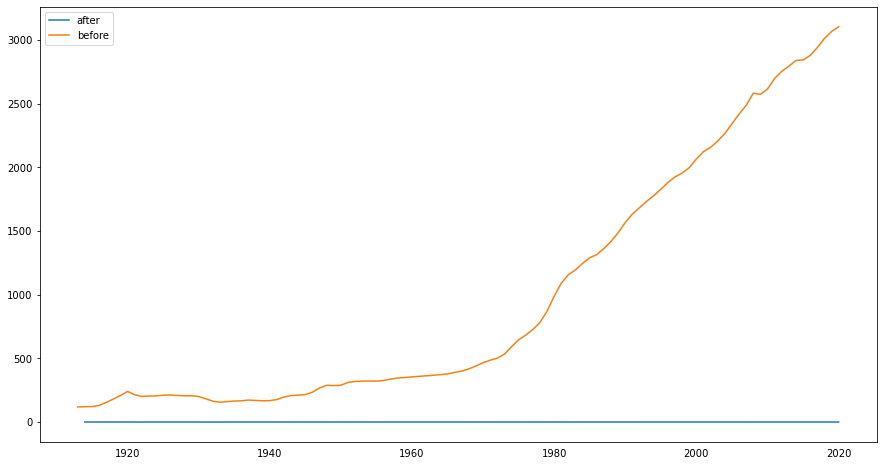

In [124]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['Cpi'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

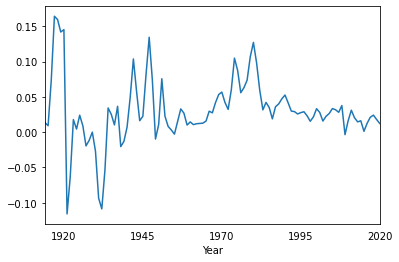

In [125]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [126]:
# First order 
#month['Rate_diff'] = month['Rate'].diff(periods=12)
#month['Rate'] = month.dropna()

In [127]:
# Autocorrelation
acf_month = acf(month['Cpi'])
acf_month

array([ 1.        ,  0.97226177,  0.94376403,  0.91502436,  0.886538  ,
        0.8582401 ,  0.82958629,  0.79984949,  0.77005225,  0.73962653,
        0.70905068,  0.67903199,  0.64867557,  0.61695212,  0.58617789,
        0.55576657,  0.52590167,  0.49665389,  0.46761193,  0.43849604,
        0.40901101,  0.37980182,  0.35119183,  0.32264484,  0.29384551,
        0.26517594,  0.23680402,  0.20863375,  0.18058638,  0.1528698 ,
        0.12562478,  0.0991824 ,  0.0737833 ,  0.049211  ,  0.02533696,
        0.00220955, -0.02072474, -0.04325359, -0.06520567, -0.08669941,
       -0.10716312])

Nice, we can definitely tell the difference, but let's see if we can do better

Most important is ?

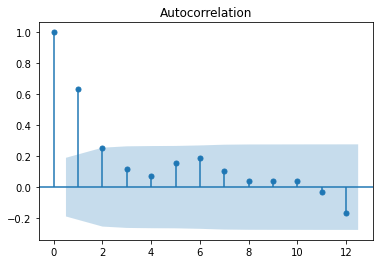

In [128]:
plot_acf(month_diff, lags=12);

In [129]:
# Partial autocorrelation
pacf_month = pacf(month['Cpi'])
pacf_month.round(2)

array([ 1.  ,  0.98, -0.04, -0.03, -0.01, -0.02, -0.03, -0.05, -0.02,
       -0.04, -0.03, -0.01, -0.04, -0.07,  0.  , -0.02, -0.02, -0.01,
       -0.02, -0.03, -0.05, -0.02, -0.02, -0.04, -0.05, -0.04, -0.03,
       -0.04, -0.04, -0.04, -0.03, -0.02, -0.01, -0.02, -0.03, -0.03,
       -0.05, -0.05, -0.04, -0.05, -0.03])

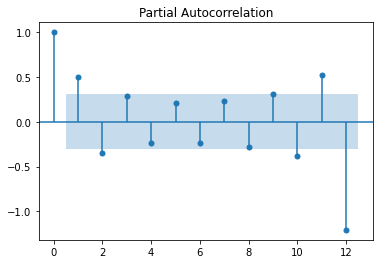

In [130]:
plot_pacf(pacf_month, lags=12);

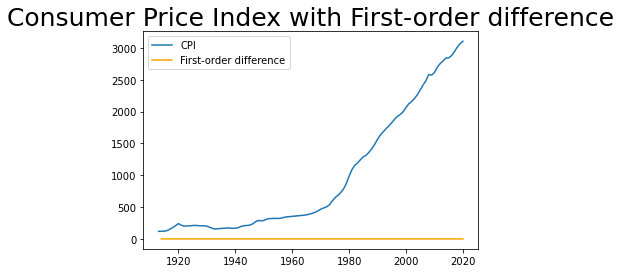

In [131]:
# Visualize our plots
plt.title('Consumer Price Index with First-order difference', size=25)
plt.plot(month['Cpi'], label='CPI')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();


## Auto-ARIMA

In [132]:
from pmdarima import auto_arima

month_fit = auto_arima(month_diff,start_p=1, d=0, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

month_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-306.949, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-241.643, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-326.632, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-316.789, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-243.282, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-325.804, Time=2.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-327.542, Time=0.65 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-328.911, Time=0.74 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-327.315, Time=1.23 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-325.914, Time=1.33 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-333.454, Time=0.70 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-312.584, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-331.984, Time=0.75 sec
 ARIMA(2,0,0)(0,1,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 174.507
Date:                            Sun, 17 Jul 2022   AIC                           -341.013
Time:                                    11:42:31   BIC                           -330.798
Sample:                                         0   HQIC                          -336.885
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3824      0.071      5.351      0.000       0.242       0.522
ma.L1          0.5712      0.117      4.876      0.000       0.342       0.801
ma.S.L12      -0.6754      0.120     -5.650      0.000      -0.910      -0.441
sigma2         0.0014      0.000      8.384      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               124.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [139]:
# Without validation
#train = month['Cpi'][:-105]
#test = month['Cpi'][-105:]
train = month['Cpi'].iloc[:len(month['Cpi'])-3]
test = month['Cpi'].iloc[len(month['Cpi'])-3:] 

In [163]:
# Split data into train / test sets
train = month['Cpi'].iloc[:len(month['Cpi'])-3]
test = month['Cpi'].iloc[len(month['Cpi'])-3:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train,
                order = (1, 0, 12))
  
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38861D+02    |proj g|=  3.12609D+02

At iterate    5    f=  5.02172D+00    |proj g|=  2.60721D-01

At iterate   10    f=  4.67138D+00    |proj g|=  2.91920D-01

At iterate   15    f=  4.48146D+00    |proj g|=  1.48152D-01

At iterate   20    f=  4.43391D+00    |proj g|=  7.53451D-02

At iterate   25    f=  4.42177D+00    |proj g|=  1.00263D-01

At iterate   30    f=  4.41258D+00    |proj g|=  7.34408D-02

At iterate   35    f=  4.37890D+00    |proj g|=  7.56805D-02

At iterate   40    f=  4.37114D+00    |proj g|=  1.70024D-02

At iterate   45    f=  4.35805D+00    |proj g|=  1.57302D-01

At iterate   50    f=  4.33575D+00    |proj g|=  1.70757D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Cpi   No. Observations:                  107
Model:              SARIMAX(1, 0, 12)   Log Likelihood                -463.926
Date:                Sun, 17 Jul 2022   AIC                            955.851
Time:                        11:53:42   BIC                            993.271
Sample:                    01-01-1913   HQIC                           971.021
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9966      0.006    172.827      0.000       0.985       1.008
ma.L1          0.8942     16.687      0.054      0.957     -31.812      33.600
ma.L2          0.5310     35.761      0.015      0.988     -69.560      70.622
ma.L3          0.3302      4.892      0.067      0.946      -9.258       9.918
ma.L4          0.3742     11.869      0.032      0.975     -22.888      23.636
ma.L5          0.2647     28.485      0.009      0.993     -55.565      56.095
ma.L6          0.4089      5.740      0.071      0.943     -10.842      11.660
ma.L7          0.2245     16.344      0.014      0.989     -31.809      32.258
ma.L8          0.2789     26.992      0.010      0.992     -52.624      53.182
ma.L9          0.2394      7.933      0.030      0.976     -15.310      15.789
ma.L10         0.3317     18.902      0.018      0.986     -36.715      37.379
ma.L11         0.9406     22.485      0.042      0.967     -43.130      45.011
ma.L12         0.7420     26.941      0.028      0.978     -52.062      53.546
sigma2       316.3160   1.15e+04      0.028      0.978   -2.22e+04    2.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                39.43
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

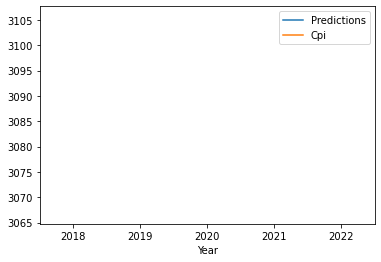

In [164]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

In [103]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Mse - always non-negative and values close to zero are better
# Incorporates both the variance of the estimator and its bias.

rmse(test, predictions)
mean_squared_error(test, predictions)

1701381.6093058842

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78768D-01    |proj g|=  4.18212D-01

At iterate    5    f=  4.55447D-01    |proj g|=  9.05535D-03

At iterate   10    f=  4.53726D-01    |proj g|=  3.39751D-02

At iterate   15    f=  4.38783D-01    |proj g|=  1.97481D-02

At iterate   20    f=  4.37914D-01    |proj g|=  8.11173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     35      1     0     0   1.711D-04   4.379D-01
  F =  0.43791299394802530     

CONVERG

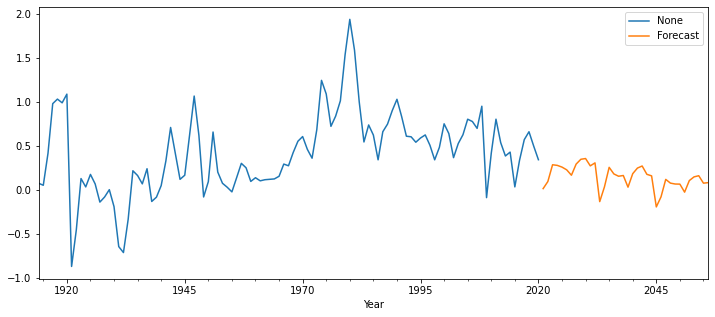

In [68]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);


In [180]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(month, test_size=len(test),  
#                              random_state=42)

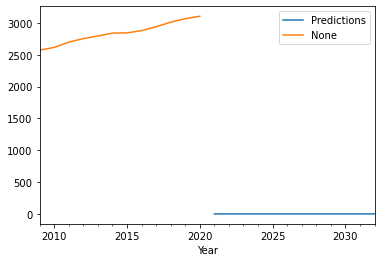

In [69]:
start = len(month_diff)
end = len(month_diff) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);


### Alternate version


In [178]:
mod = sm.tsa.statespace.SARIMAX(month_diff, order=(2,1,1), seasonal_order=(1,1,0,100), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          D.DS100.Jan   No. Observations:                    6
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 100)   Log Likelihood                   6.201
Date:                              Sun, 17 Jul 2022   AIC                             -2.402
Time:                                      00:39:40   BIC                             -3.443
Sample:                                  01-01-2015   HQIC                            -6.570
                                       - 01-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2636      2.906     -0.091      0.928      -5.960       5.433
ar.L2         -0.43

In [179]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

,lower D.DS100.Jan,upper D.DS100.Jan
2015-01-01,-0.187692,0.187692
2016-01-01,-0.197454,0.176173
2017-01-01,-0.101536,0.228092
2018-01-01,-0.243448,0.076101
2019-01-01,-0.130516,0.186059
2020-01-01,-0.117566,0.198072
